# AUEB M.Sc. in Data Science (part-time)

**Course**: Machine Learning and Computational Statistics

**Semester**: Winter 2018

**Final Project**

**Author**: Spiros Politis

---

## Imports and global functions

In [1]:
import numpy as np
import numpy.ma as npma

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Dictionary of endmembers and their associated labels
endmembers_dict = {
    1: "Water", 
    2: "Trees", 
    3: "Asphalt", 
    4: "Self-Blocking Bricks", 
    5: "Bitumen", 
    6: "Tiles", 
    7: "Shadows", 
    8: "Meadows", 
    9: "Bare Soil"
}

In [3]:
# Aesthetics for plots
plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

### Data sets import

In [4]:
import scipy.io as sio

In [5]:
pavia = sio.loadmat("PaviaU_cube.mat")
    
# Pavia HSI : 300x200x103
# This cube represents the spatial (MxN) and spectral signature (L) vectors
hsi = pavia["X"]

# Endmember's matrix: 103x9
# This matrix represents the spectral components of the 9 classes of pure materials (endmembers)
ends = sio.loadmat("PaviaU_endmembers.mat")
endmembers = ends["endmembers"]

# Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat("PaviaU_ground_truth.mat")
labels = ground_truth["y"]

### Initial visualizations

Endmembers spectral signatures of Pavia University HSI:

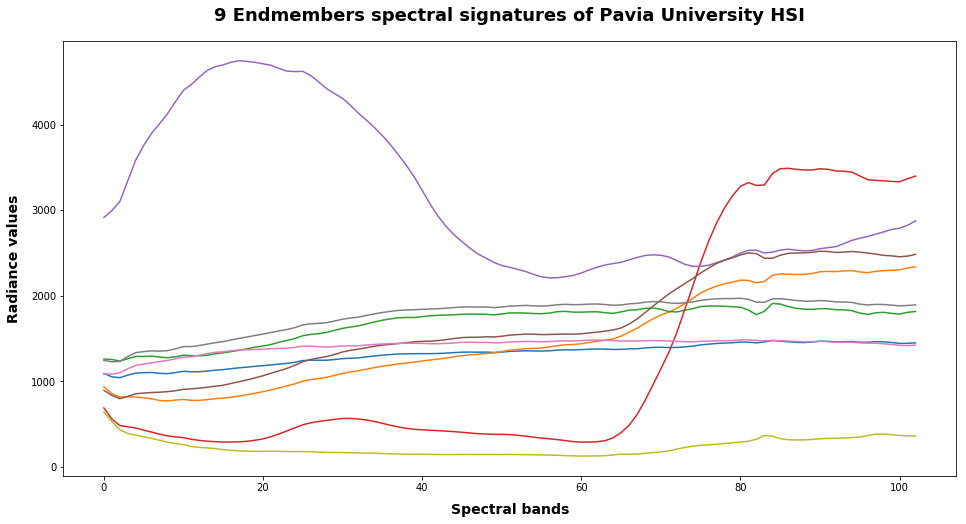

In [6]:
# Plot
fig, ax = plt.subplots(figsize = (16, 8))

ax.plot(endmembers)

# Set graph labels
ax.set_xlabel("Spectral bands", fontdict = plot_axis_title_font, labelpad = 10)
ax.set_ylabel("Radiance values", fontdict = plot_axis_title_font, labelpad = 10)

# Set graph title
ax.set_title("9 Endmembers spectral signatures of Pavia University HSI", fontdict = plot_main_title_font, pad = 20)

pass;

RGB Visualization of the 10th band of Pavia University HSI:

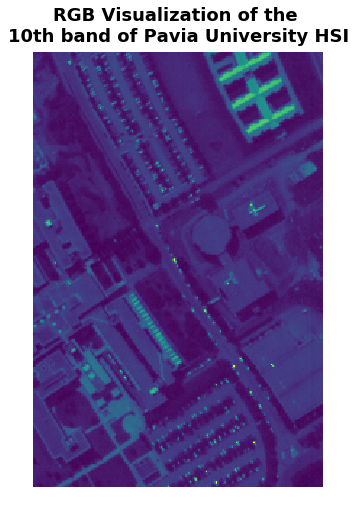

In [7]:
# Plot
fig, ax = plt.subplots(figsize = (8, 8))

plt.axis("off")

plt.imshow(hsi[:, :, 10], alpha = 1)

# Set graph title
plt.title("RGB Visualization of the \n10th band of Pavia University HSI", loc = "center", fontdict = plot_main_title_font, pad = 10)

pass

In [8]:
# Trainining set for classification
pavia_labels = sio.loadmat("classification_labels_Pavia.mat")
training_set = (np.reshape(pavia_labels["training_set"], (200, 300))).T
test_set = (np.reshape(pavia_labels["test_set"], (200, 300))).T
operational_set = (np.reshape(pavia_labels["operational_set"], (200, 300))).T

Labels of the pixels of the training set:

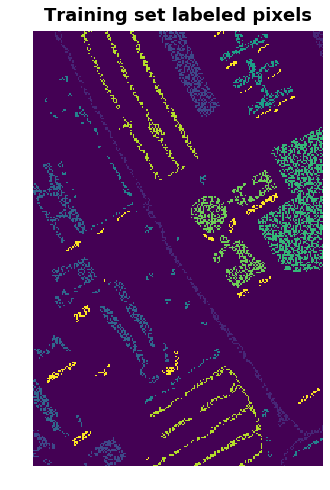

In [9]:
# Plot
fig, ax = plt.subplots(figsize = (8, 8))

plt.axis("off")

plt.imshow(training_set)

# Set graph title
plt.title("Training set labeled pixels", loc = "center", fontdict = plot_main_title_font, pad = 10)

pass;

---

In [10]:
'''
    Helper function that returns dimensions of data structures
    used in part 1 of the project
    
    :returns: (M, N, L, C) tupple of dimensions of the HSI structure (M, N, L) and number of classes (C) 
'''
def get_dimensions_1():
    # Dimensions of the HSI cube
    M = hsi.shape[0]
    N = hsi.shape[1]
    L = hsi.shape[2]
    
    # Number of classes
    C = endmembers.shape[1]
    
    return M, N, L, C


def plot_abundance_maps(abundance_maps, endmembers_dict, method):
    # Number of plot columns
    plot_cols = 3

    # Axis counters
    ax_1 = 0
    ax_2 = 0

    # Setup the plot
    fig, ax = plt.subplots(nrows = 3, ncols = plot_cols, figsize = (15, 25))

    for i in range(0, C):
        if(i > 1 and i % plot_cols == 0):
            ax_1 += 1
        ax_2 = (i % plot_cols)

        ax[ax_1, ax_2].set_xticks([])
        ax[ax_1, ax_2].set_yticks([])

        ax[ax_1, ax_2].imshow(abundance_maps[:, :, i], cmap = "binary")

        # Set graph title
        ax[ax_1, ax_2].set_title(label = endmembers_dict[i + 1] + "\n" + "(" + method + ")", loc = "center", fontdict = plot_main_title_font, pad = 10)

## Part 1 (spectral unmixing)

Reformulation of the problem statement:

- Let $x_{1}, x_{2}, \dots, x_{n}$ be the a vector with the spectral signature of "pure" materials.


- Our goal is to rewrite any other pixel in the image as a linear combination of such "pure" pixels.


- Therefore, given the spectral signature vector of "pure" pixels, for every pixel in the image we need to determine the coefficients $\boldsymbol{\theta}$ = $\theta_{1}, \theta_{2}, \dots, \theta_{n}$, i.e. the weights by which each "pure" spectral coefficient is present in the specific pixel.


Remark:


- Due to the physical properties of the problem, a desirable property of the parameter vector $\boldsymbol{\theta}$ is that $\theta_{i}$'s are not negative and that they ideally sum to one.

Therefore, we adopt the linear spectral unmixing hypothesis, such that:

$$y = X \boldsymbol{\theta} + \eta$$

where 

$y$: the (column L-dimensional) spectral signature of the pixel under study.

$X$: the spectral signatures (column L-dimensional vectors) of the pure pixels in the image (each one corresponding to a pure material met in the image).

$\boldsymbol{\theta}$: the m-dimensional **abundance vector** of the pixel (its q-th coordinate corresponds to the percentage to which the q-th pure pixel contributes to the formation of the pixel under study).

$\eta$: the L-dimensional i.i.d., zero mean Gaussian vector which represents noise in our data.

Therefore, supposing that:
    
- Each "pure" pixel vector can be represented as a linear model, thereby providing us with 9 linear models (1 per class of "pure" pixels)


- We need to estimate the fit of each image pixel spectral coefficients to each of the "pure" linear models

On a final note, we chose to retain the initial MxNxL dimensions of the original HSI while performing unmixing operations, albeit having an impact on performance (not vectorized operations), for the sake of easier visualization of abundance maps. As an example, computing the OLS abundance maps would be as easy as performing a 'np.linalg.inv(X.T.dot(X)).dot(X.T).T.dot(y)' operation instead of looping through the MxN matrix. However, reconstructing the matrix in an easy for matplotlib format to process would be harder.

### (a) Least squares

Stacking the data vectors as rows in the matrix $X$ leads to the alternative representation

$$X^{T}X\hat{\theta} = X^{T}\boldsymbol{y}$$

which, provided that $X^{T}X$ is **invertible**, gives the least squares estimator of $\theta$

$$\hat{\boldsymbol{\theta}}_{OLS} = (X^{T}X)^{-1}X^{T}\boldsymbol{y}$$

In [11]:
'''
    Vectorized implementation of computing the estimated θ vector (theta hat).
    
    :param X: Numpy matrix (X)
    :param y: Numpy vector (y)
    
    :returns: Numpy column vector (theta hat)
'''
def compute_theta_hat_ols(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)



'''
    Performs spectral unmixing.
    
    :param hsi: high-spectral image matrix
    :param X: endmembers matrix
    :param labels: labeled HSI pixels
    
    :returns: MxNxC Numpy matrix
'''
def spectral_unmixing_ols(hsi, X, labels):
    M, N, L, C = get_dimensions_1()
    
    thetas = np.zeros((M, N, C), np.float64)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                thetas[i, j, :] = compute_theta_hat_ols(X, hsi[i, j, :]).reshape(1, C)
                
    return thetas


'''
    For each (non-zero class label) pixel yi compute the quantity ||yi−Xθi||2 
    and then take the average over those pixels).
'''
def compute_reconstruction_error_ols(hsi, X, abundance_maps, labels):
    M, N, L, C = get_dimensions_1()
    
    errors = np.empty((M, N, L))
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                errors[i, j, :] = np.power(np.linalg.norm(hsi[i, j, :] - X.dot(abundance_maps[i, j, :])), 2)
    
    # Reshape to M*NxL
    errors = errors.reshape(M * N, L)
    # Filter zeros
    errors = errors[np.nonzero(errors)]
    
    return np.mean(errors)

#### Compute abundance maps

In [12]:
M, N, L, C = get_dimensions_1()

X = endmembers.reshape(L, C)
abundance_maps_ols = spectral_unmixing_ols(hsi, X, labels)

#### Visualize abundance maps

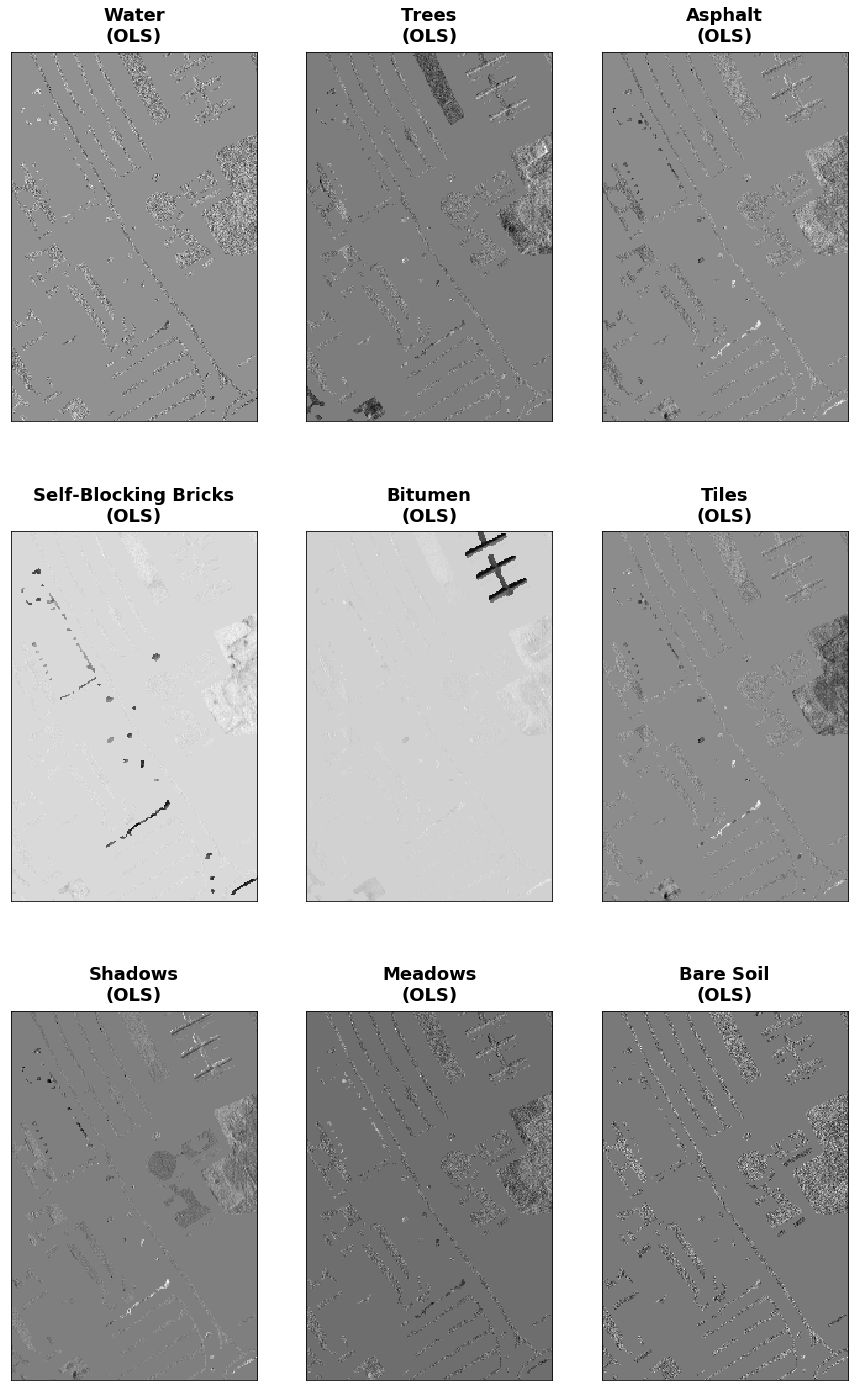

In [13]:
plot_abundance_maps(abundance_maps_ols, endmembers_dict, "OLS")

#### Compute reconstruction error for OLS method

In [14]:
reconstruction_error_ols = compute_reconstruction_error_ols(hsi, X, abundance_maps_ols, labels)

reconstruction_error_ols_df = pd.DataFrame([
    ["{:f}".format(reconstruction_error_ols)]
], columns = ["Reconstruction error (OLS)"])
reconstruction_error_ols_df

,Reconstruction error (OLS)
0,118783.180626


---

### (b) Least squares imposing the sum-to-one constraint

This is a problem where we want to minimize a function subject to a constraint that the sum of some function of the parameters, e.g., their sum of squares, must equal some constant. These problems are reffered to as *sumscale* optimization problems.

In our case, our goal is to minimize the cost function (LS criterion):

$$
J(\boldsymbol{\theta}) = \sum_{i=1}^{N} (y_{i} - \boldsymbol{\theta}^{T} \boldsymbol{x}_{i})^{2}
$$

subject to the constraint that the sum of parameters $\theta$ is approximately $1$, expressed as:

$$
\sum_{i=1}^{N} \theta_{i} \approx 1, i = 1, 2, \dots, 9
$$

Solving the problem with *scipy.optimize.least_squares* requires that we define the loss function:

$$
L(y_{i}, f_{\theta}(x_{i})) = (y_{i} - \boldsymbol{\theta}^{Τ} x_{i})^{2}, i = 1, 2, \dots, N
$$

In [15]:
from scipy.optimize import minimize

In [16]:
'''
    Definition of the minimization loss function
    
    :param x: 
    :param X: 
    :param y: 
    
    :returns: constraint criterion
'''
def loss_function(x, X, y):
    return np.sum(np.square((np.dot(x, X) - y)))



'''
    Performs spectral unmixing imposing the sum-to-one constraint
    for theta parameters.
    
    :param hsi: high-spectral image matrix
    :param X: endmembers matrix
    
    :returns: MxNxC Numpy matrix
'''
def spectral_unmixing_sum_to_one(hsi, X, labels):
    M, N, L, C = get_dimensions_1()
    
    # Sum-to-one constraint
    constraints = ({
        "type": "eq",
        "fun": lambda x: np.sum(x) - 1.0
    })
    
    # Initialization of parameters for the minimization function
    x0 = np.zeros(X.shape[0])
    
    thetas = np.zeros((M, N, C), np.float64)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                thetas[i, j, :] = minimize(loss_function, x0, method = "SLSQP", constraints = constraints, args = (X, hsi[i, j, :].reshape(1, L))).x
                
    return thetas


'''
    For each (non-zero class label) pixel yi compute the quantity ||yi−Xθi||2 
    and then take the average over those pixels).
'''
def compute_reconstruction_error_sum_to_one(hsi, X, abundance_maps, labels):
    M, N, L, C = get_dimensions_1()
    
    errors = np.empty((M, N, L))
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                errors[i, j, :] = np.power(np.linalg.norm(hsi[i, j, :] - X.T.dot(abundance_maps[i, j, :])), 2)
    
    # Reshape to M*NxL
    errors = errors.reshape(M * N, L)
    # Filter zeros
    errors = errors[np.nonzero(errors)]
    
    return np.mean(errors)

#### Compute abundance maps for the constrained sum-to-one OLS method

In [17]:
M, N, L, C = get_dimensions_1()

X = endmembers.reshape(C, L)
abundance_maps_sum_to_one = spectral_unmixing_sum_to_one(hsi, X, labels)

#### Visualize abundance maps for the constrained sum-to-one OLS method

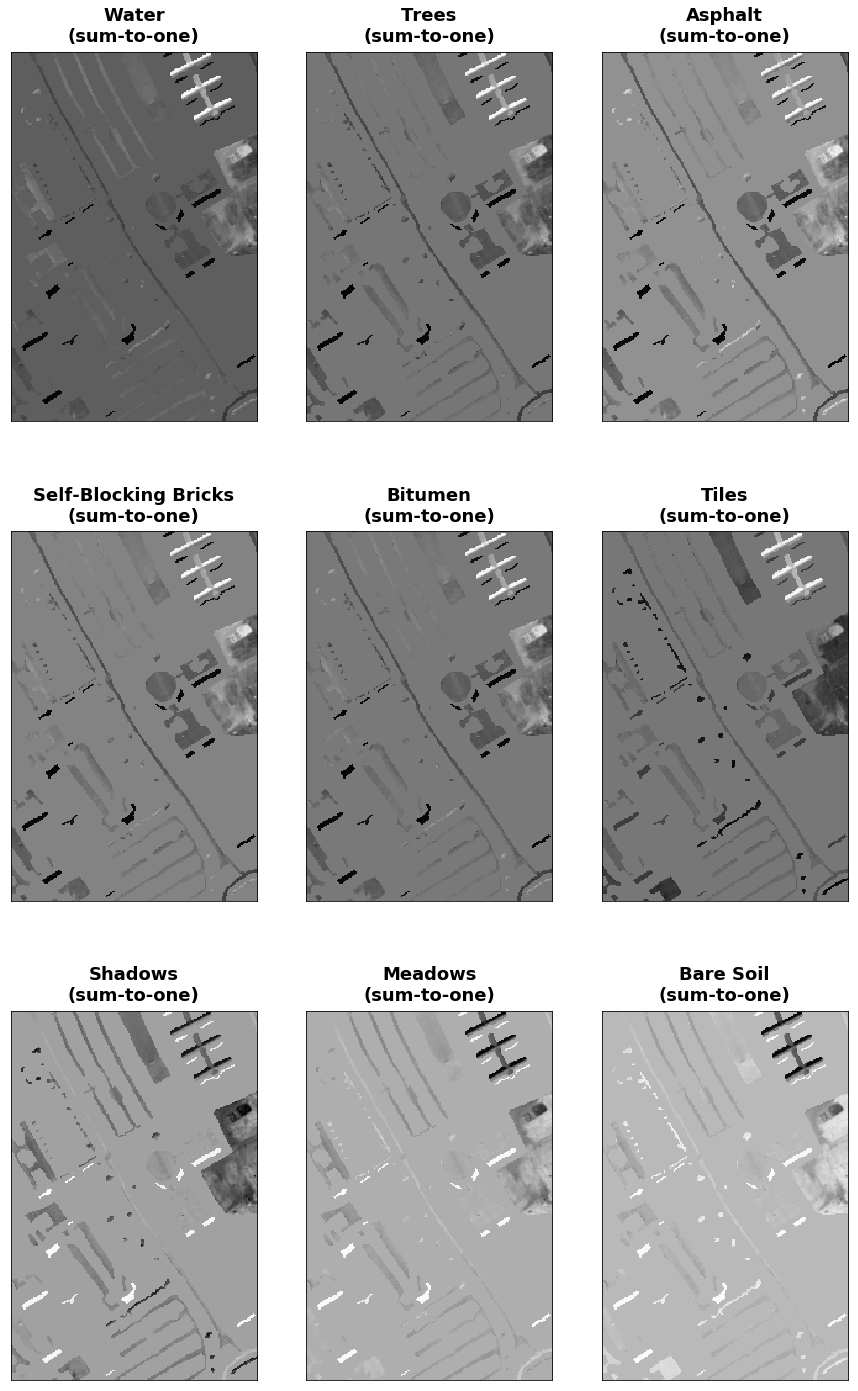

In [18]:
plot_abundance_maps(abundance_maps_sum_to_one, endmembers_dict, "sum-to-one")

#### Compute reconstruction error for the constrained sum-to-one OLS method

In [19]:
reconstruction_error_sum_to_one = compute_reconstruction_error_sum_to_one(hsi, X, abundance_maps_sum_to_one, labels)

reconstruction_error_sum_to_one_df = pd.DataFrame([
    ["{:f}".format(reconstruction_error_sum_to_one)]
], columns = ["Reconstruction error (sum-to-one)"])
reconstruction_error_sum_to_one_df

,Reconstruction error (sum-to-one)
0,29801120.268971


---

#### (c) Least squares imposing the non-negativity constraint on the entries of $\boldsymbol{\theta}$

The problem of non-negative least squares (NNLS) is a type of constrained least squares problem where the coefficients are not allowed to become negative. That is, given a matrix $A$ and a (column) vector of response variables $y$, the goal is to find

$$argmin_{x} || \boldsymbol{A}\boldsymbol{x} - \boldsymbol{b} ||_{2} \text{ for } \boldsymbol{x} \geq 0$$

where:

$\boldsymbol{A}\boldsymbol{x}$: the system of linear equations $\theta_{1}x_{1} + \theta_{2}x_{2} + \dots + \theta_{N}x_{N}$, in matrix form

$\boldsymbol{b}$: the $y$ column vector

Proceeding with the implementation, using the *SciPy NNLS* package:

In [20]:
from scipy.optimize import nnls

In [21]:
'''
    Performs spectral unmixing.
    
    :param hsi: high-spectral image matrix
    :param X: endmembers matrix
    
    :returns: MxNxC Numpy matrix
'''
def spectral_unmixing_nnls(hsi, X, labels):
    M, N, L, C = get_dimensions_1()
    
    thetas = np.zeros((M, N, C), np.float64)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                
                # Variables assigned for notational alignment with SciPy
                A = X
                b = hsi[i, j, :].reshape(L, 1)[:, 0]
                
                thetas[i, j, :] = nnls(A, b)[0]
                
    return thetas



'''
    For each (non-zero class label) pixel yi compute the quantity ||yi−Xθi||2 
    and then take the average over those pixels).
'''
def compute_reconstruction_error_nnls(hsi, X, abundance_maps, labels):
    M, N, L, C = get_dimensions_1()
    
    errors = np.empty((M, N, L))
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                errors[i, j, :] = np.power(np.linalg.norm(hsi[i, j, :] - X.dot(abundance_maps[i, j, :])), 2)
    
    # Reshape to M*NxL
    errors = errors.reshape(M * N, L)
    # Filter zeros
    errors = errors[np.nonzero(errors)]
    
    return np.mean(errors)

In [22]:
M, N, L, C = get_dimensions_1()

X = endmembers.reshape(L, C)
abundance_maps_nnls = spectral_unmixing_nnls(hsi, X, labels)

#### Visualize abundance maps for the least squares imposing the non-negativity constraint on the entries of $\boldsymbol{\theta}$ method

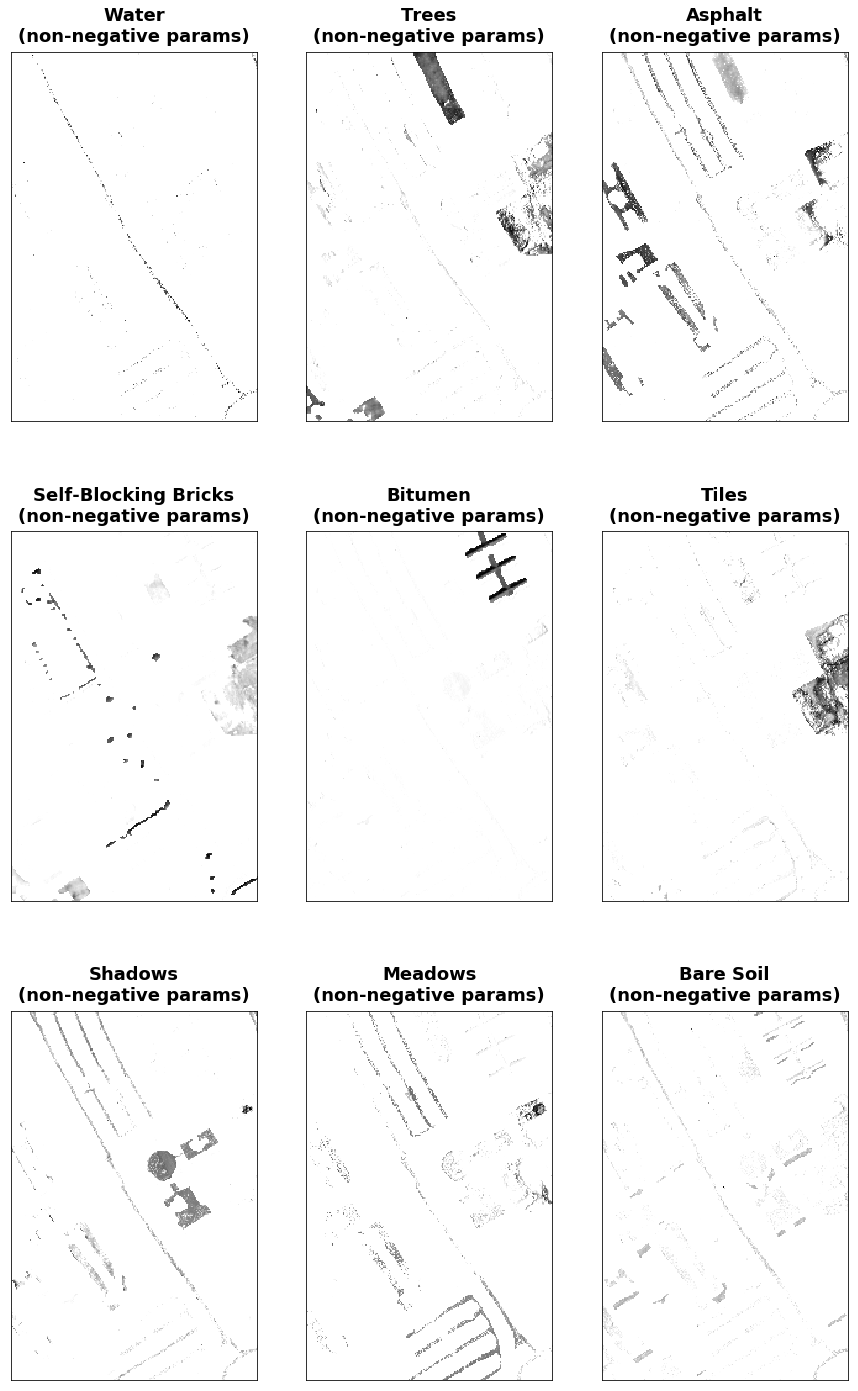

In [23]:
plot_abundance_maps(abundance_maps_nnls, endmembers_dict, "non-negative params")

#### Compute reconstruction error for least squares imposing the non-negativity constraint on the entries of $\boldsymbol{\theta}$

In [24]:
reconstruction_error_nnls = compute_reconstruction_error_nnls(hsi, X, abundance_maps_nnls, labels)

reconstruction_error_nnls_df = pd.DataFrame([
    ["{:f}".format(reconstruction_error_nnls)]
], columns = ["Reconstruction error (NNLS)"])
reconstruction_error_nnls_df

,Reconstruction error (NNLS)
0,569339.291056


---

#### (d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of $\boldsymbol{\theta}$

In [25]:
from scipy.optimize import minimize

In [26]:
'''
    Constrain all elements of x to be >= 0
'''
def nn_constraint(x):
    return x



'''
    Constrain the sum of parameters to be equal to 1
'''
def sum_to_one_constraint(x):
    return np.sum(x, axis = 0) - 1



'''
    Definition of the minimization loss function
    
    :param x: minimization function parameter vector
    :param X: example x_{i}
    :param y: example y_{i}
    
    :returns: constraint criterion
'''
def loss_function(x, X, y):
    x = x.reshape(1, 9)

    return np.sum(np.square((np.dot(x, X.T) - y)))



'''
    Performs spectral unmixing imposing the sum-to-one constraint
    for theta parameters.
    
    :param hsi: high-spectral image matrix
    :param X: endmembers matrix
    
    :returns: MxNxC Numpy matrix
'''
def spectral_unmixing_nn_sum_to_one(hsi, X, labels):
    M, N, L, C = get_dimensions_1()
    
    constraints = [
        {
            "type": "ineq", 
            "fun": nn_constraint
        },
        {
            "type": "eq", 
            "fun": sum_to_one_constraint
        }
    ]
    
    thetas = np.zeros((M, N, C), np.float64)
    
    # Get the previously defined contrstrained thetas matrix from NNLS method
    x = spectral_unmixing_nnls(hsi, X, labels)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]
            
            if label != 0:
                # Get a specific NNLS theta as an initialization parameter
                x0 = x[i, j, :]
                
                thetas[i, j, :] = minimize(loss_function, x0, method = "SLSQP", constraints = constraints, args = (X, hsi[i, j, :])).x
        
                
    return thetas



'''
    For each (non-zero class label) pixel yi compute the quantity ||yi−Xθi||2 
    and then take the average over those pixels).
'''
def compute_reconstruction_error_nn_sum_to_one(hsi, X, abundance_maps, labels):
    M, N, L, C = get_dimensions_1()
    
    errors = np.empty((M, N, L))
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                errors[i, j, :] = np.power(np.linalg.norm(hsi[i, j, :] - X.dot(abundance_maps[i, j, :])), 2)
    
    # Reshape to M*NxL
    errors = errors.reshape(M * N, L)
    # Filter zeros
    errors = errors[np.nonzero(errors)]
    
    return np.mean(errors)

In [27]:
M, N, L, C = get_dimensions_1()

X = endmembers.reshape(L, C)
abundance_maps_nn_sum_to_one = spectral_unmixing_nn_sum_to_one(hsi, X, labels)

#### Visualize abundance maps for the least squares imposing the non-negativity and sum-to-one constraint on the entries of $\boldsymbol{\theta}$ method

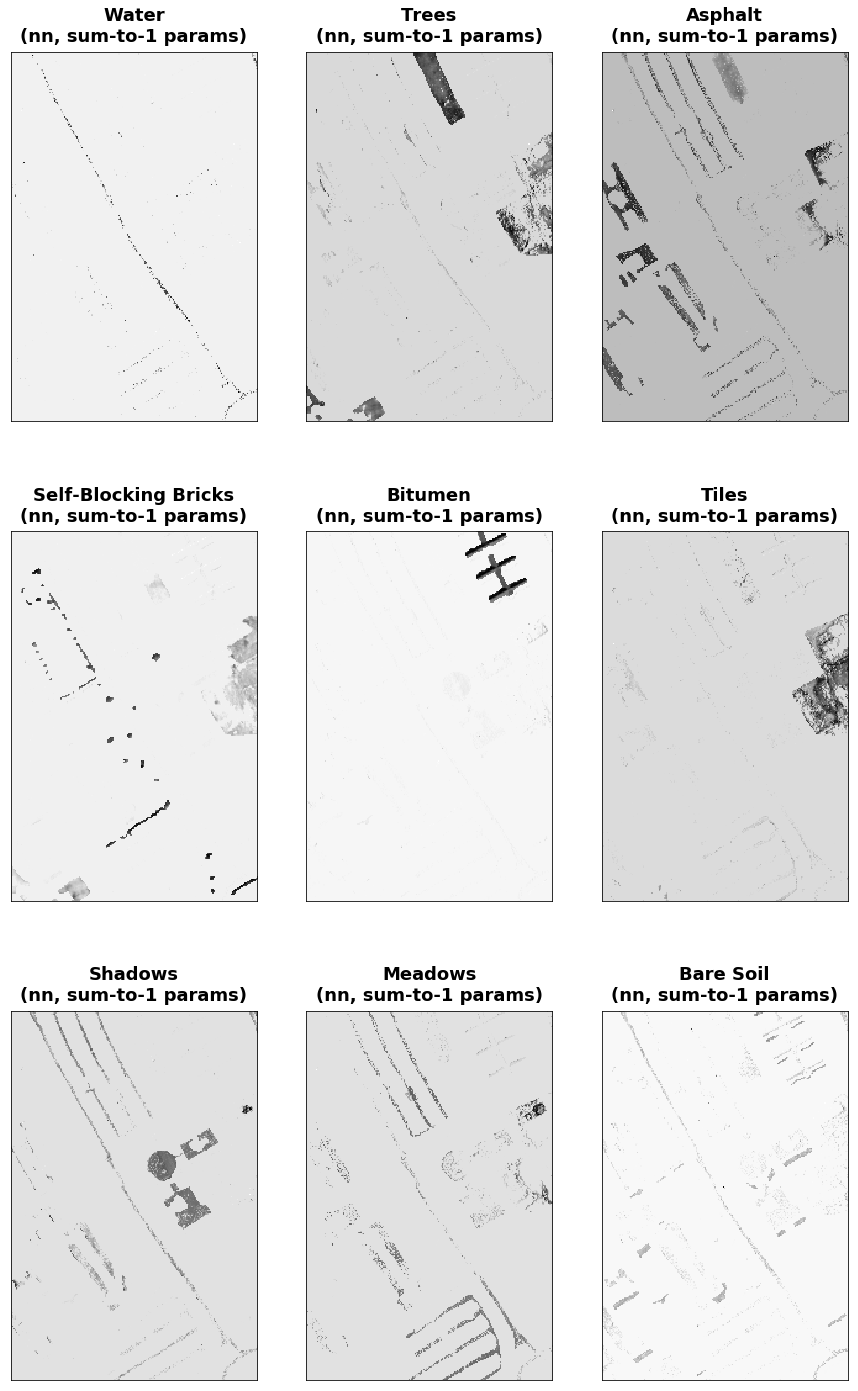

In [28]:
plot_abundance_maps(abundance_maps_nn_sum_to_one, endmembers_dict, "nn, sum-to-1 params")

In [29]:
reconstruction_error_nn_sum_to_one = compute_reconstruction_error_nn_sum_to_one(hsi, X, abundance_maps_nn_sum_to_one, labels)

reconstruction_error_nn_sum_to_one_df = pd.DataFrame([
    ["{:f}".format(reconstruction_error_nn_sum_to_one)]
], columns = ["Reconstruction error (NN, sum-to-one)"])
reconstruction_error_nn_sum_to_one_df

,"Reconstruction error (NN, sum-to-one)"
0,570745.425476


---

#### (e) LASSO, i.e., impose sparsity on $\boldsymbol{\theta}$ via $\ell_{1}$ norm minimization

LASSO is used to penalize parameters whose contribution in the overal $Ε[y|x]$ is low.

In [30]:
from sklearn import linear_model

In [31]:
def compute_theta_hat_lasso(X, y):
    lasso_model = linear_model.Lasso(alpha = 10, fit_intercept = False, max_iter = 2000, tol = 0.1, random_state = 19730618)
    lasso_model.fit(X, y)
    
    return lasso_model.coef_



'''
    Performs spectral unmixing for the LASSO method.
    
    :param hsi: high-spectral image matrix
    :param X: endmembers matrix
    
    :returns: MxNxC Numpy matrix
'''
def spectral_unmixing_lasso(hsi, X, labels):
    M, N, L, C = get_dimensions_1()
    
    thetas = np.zeros((M, N, C), np.float64)
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]
            
            # For non-zero label pixels...
            if label != 0:
                thetas[i, j, :] = compute_theta_hat_lasso(X, hsi[i, j, :]).reshape(1, C)
                
    return thetas


'''
    For each (non-zero class label) pixel yi compute the quantity ||yi−Xθi||2 
    and then take the average over those pixels).
'''
def compute_reconstruction_error_lasso(hsi, X, abundance_maps, labels):
    M, N, L, C = get_dimensions_1()
    
    errors = np.empty((M, N, L))
    
    for i in range(0, M):
        for j in range(0, N):
            # Get the label of the corresponding pixel at i, j
            label = labels[i, j]

            if label != 0:
                errors[i, j, :] = np.power(np.linalg.norm(hsi[i, j, :] - X.dot(abundance_maps[i, j, :])), 2)
    
    # Reshape to M*NxL
    errors = errors.reshape(M * N, L)
    # Filter zeros
    errors = errors[np.nonzero(errors)]
    
    return np.mean(errors)

In [32]:
M, N, L, C = get_dimensions_1()

X = endmembers.reshape(L, C)
abundance_maps_lasso = spectral_unmixing_lasso(hsi, X, labels)

#### Visualize abundance maps for the LASSO (imposing sparsity on $\boldsymbol{\theta}$ via $\ell_{1}$ norm) minimization method

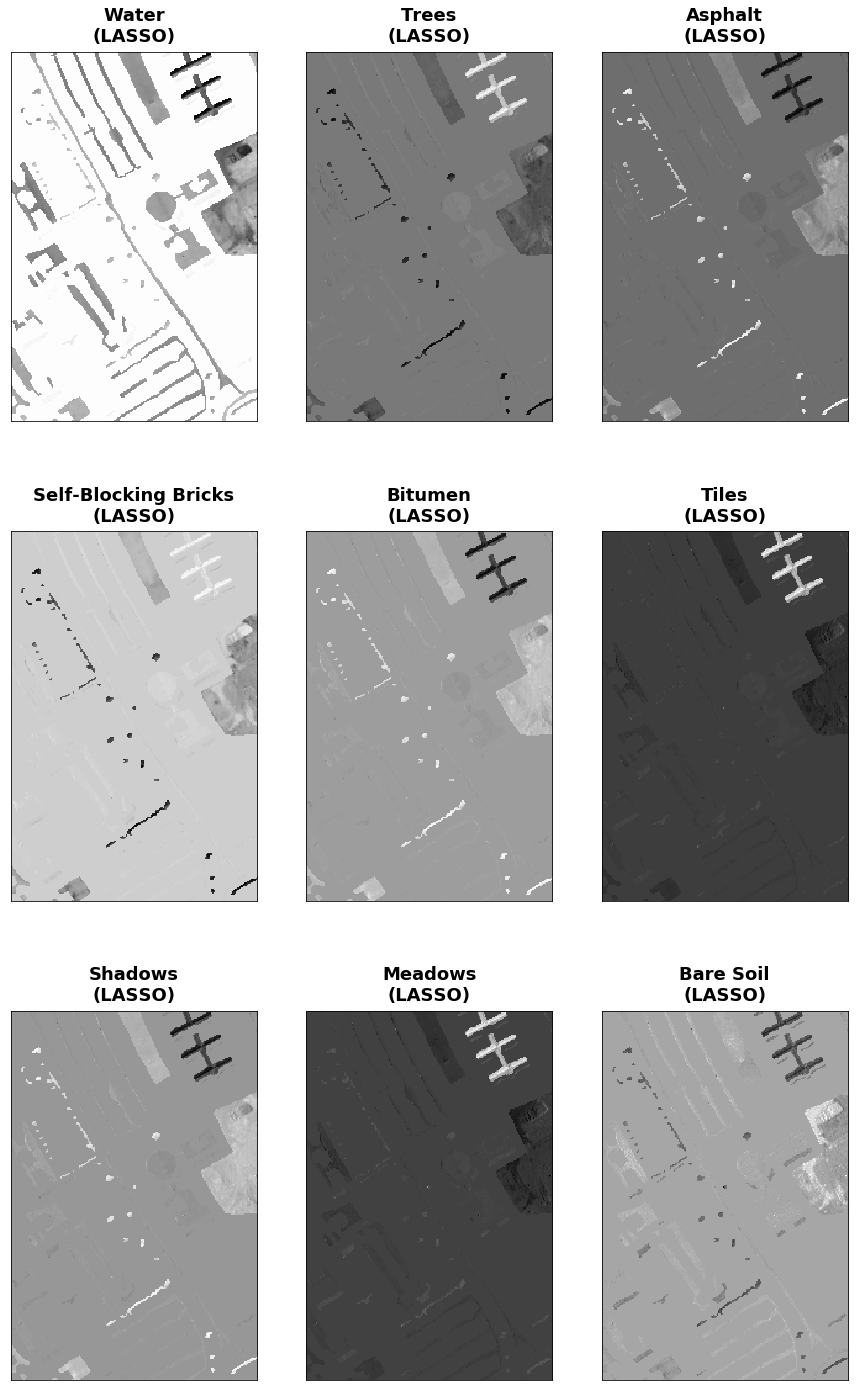

In [33]:
plot_abundance_maps(abundance_maps_lasso, endmembers_dict, "LASSO")

#### Compute reconstruction error for LASSO (imposing sparsity on $\boldsymbol{\theta}$ via $\ell_{1}$ norm) minimization method

In [34]:
reconstruction_error_lasso = compute_reconstruction_error_lasso(hsi, X, abundance_maps_lasso, labels)

reconstruction_error_lasso_df = pd.DataFrame([
    ["{:f}".format(reconstruction_error_lasso)]
], columns = ["Reconstruction error (LASSO)"])
reconstruction_error_lasso_df

,Reconstruction error (LASSO)
0,2507703.053565


---

### Part 1 commentary

Commenting on the 1st part, we evaluate each one of the methods employed:


- Ordinary Least Squares: we expect this method to be the least performant, in terms of estimating the abundance vector of each pixel. The reason fo this is that the method does not take into consideration physical aspects of the problem, such as  the parameters $\boldsymbol{\theta}$ of the linear relationship not being negative, which would be non-sensical, as well as not impossing a meaningful constraint of weighing the parameters in such a way that the contribution of each "pure" pixel is a a percentage, related to the total contribution of "pure" pixels.


- Least squares imposing the sum-to-one constraint on $\boldsymbol{\theta}$: we expect this regressor to outperform OLS because it takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value.


- Least squares imposing the non-negativity constraint on $\boldsymbol{\theta}$: this method makes sure that individual $\theta$ values cannot be negative, however it does not impose the notion that every $\theta$ parameter is normalized in such a way as to represent a contribution percentage.


- Least squares imposing both the non-negativity and the sum-to-one constraint on $\boldsymbol{\theta}$: as with the two previous method, we expect this regressor to do even better it not only takes into consideration the notion that "pure" pixels contribute up to a percentage on the whole pixel value but also that their contribution has to be non-negative.


- LASSO regularization: this method penalizes values of $\boldsymbol{\theta}$ that do not have a significant contribution in the pixel value. We estimate that this method will be much more closely aligned to a classification algorithm in which a pixel's class is derived by the probability of belonging to a certain class.

We observe that the more restrictive in the estimation of $\boldsymbol{\theta}$ the method applied is, thereby more fitting to the physical properties of the problem, the visual outcome is such that "pure" pixels are more clearly represented. At the same time, the reconstruction error increases with the increased restrictions imposed on the estimation of $\boldsymbol{\theta}$.

---

## Part 2 (classification)

In [35]:
'''
    Perform 10-fold (default) cross-validation.
    
    Scores are computed as defined in the 'scoring' parameter. If the parameter is not set, 
    the estimator 'score' function is used by default.
     
    :param model: the estimator to be scored
    :param X_test: X test set
    :param y_test: y test set
    :param k_folds: number of K-folds
    :param scoring: the scoring function
    
    :returns: score metrics
'''
def cross_validate(model, X, y, n_splits = 10, shuffle = True, scoring = None):
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 19730618)

    return cross_val_score(model, X, y, cv = cv, scoring = scoring)



'''
    Returns features x_{i} for a specific class
    
    :param y_test: y test set
    :param y_pred: y vector of predictions
    
    :returns: accuracy, score
'''
def score(y_test, y_pred):
    N = y_test.shape[0]
    
    accuracy = np.count_nonzero(y_test == y_pred) / N
    error = 1 - accuracy
    
    return (accuracy, error)



'''
    Returns the estimated cross-validation metrics as a Pandas dataframe
    
    :param error: cross-validation error
    :param std: cross-validation error standard deviation
    :param caption: the dataframe caption
    
    :returns: Pandas dataframe
'''
def score_matrix_cross_val(error, std, caption = "None"):
    df = pd.DataFrame([
        [error, std]
    ], columns = ["Estimated validation error", "Estimated validation std"])
    
    df = df.style.set_caption(caption)
    
    return df



'''
    Returns the metrics (accuracy, error) of a fitted classifier as a Pandas dataframe
    
    :param accuracy: classifier accuracy
    :param error: classifier error
    :param caption: the dataframe caption
    
    :returns: Pandas dataframe
'''
def score_matrix_fitted(accuracy, error, caption = "None"):
    df = pd.DataFrame([
        [accuracy, error]
    ], columns = ["Accuracy (%)", "Error (%)"])
    
    df = df.style.set_caption(caption)
    
    return df




'''
    Returns the classification confusion matrix as a Pandas dataframe
    
    :param y_test: test set
    :param y_pred: predictions set
    :param labels: the class labels. If 'None', no labels are used
    :param caption: the dataframe caption
    
    :returns: Pandas dataframe
'''
def confusion_matrix(y_test, y_pred, labels = None, caption = None):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    confusion_matrix_df = pd.DataFrame(
        data = confusion_matrix(y_test, y_pred)
    )
    
    if labels != None:
        confusion_matrix_df = confusion_matrix_df.rename(
            columns = labels, 
            index = labels
        )
    
    cmap = sns.light_palette((210, 90, 60), input="husl", as_cmap = True)
    confusion_matrix_df = confusion_matrix_df.style.background_gradient(cmap, axis = 1).set_caption(caption)
    
    return confusion_matrix_df

In [36]:
# Labels for the confusion matrix Pandas dataframe
confusion_matrix_labels = {
    0: "Water", 
    1: "Trees", 
    2: "Asphalt", 
    3: "Self-Blocking Bricks", 
    4: "Bitumen", 
    5: "Tiles", 
    6: "Shadows", 
    7: "Meadows", 
    8: "Bare Soil"
}

Since we are considering only pixels with non-zero labels, we shall adjust our data sets accordingly for further use:

In [37]:
X_train = hsi[training_set > 0]
y_train = training_set[training_set > 0]
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = hsi[test_set > 0]
y_test = test_set[test_set > 0]
y_test = y_test.reshape(y_test.shape[0], 1)

### (i) Naïve Bayes classifier

The model of naive Bayes classifiers is based on Bayes' theorem, naive comes from the assumption that the features in the data are i.i.d. (independent and identically distributed).

Note, however, that severe violations of the independence assumptions and non-linear classification problems can lead to very poor performances of naive Bayes classifiers.

In [38]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_clf = GaussianNB()

#### Estimation of the mean and standard deviation metrics of the cross validation error of the naive Bayes classifier

In [39]:
naive_bayes_est_val_score = cross_validate(naive_bayes_clf, X_train, y_train.ravel(), n_splits = 10, shuffle = True)

score_matrix_cross_val(
    1 - np.mean(naive_bayes_est_val_score), 
    np.std(np.ones(10) - naive_bayes_est_val_score), 
    "Naive Bayes classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.341689,0.0171117


In [40]:
naive_bayes_clf = GaussianNB()
naive_bayes_clf_fitted = naive_bayes_clf.fit(X_train, y_train.ravel())

y_pred = naive_bayes_clf_fitted.predict(X_test)

accuracy, error = score(y_test.ravel(), y_pred.ravel())

score_matrix_fitted(
    accuracy, 
    error,
    "Naive Bayes classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.660118,0.339882


#### Confusion matrix of the minimum naive Bayes classifier

In [41]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Naive Bayes classifier confusion matrix")

,Water,Trees,Asphalt,Self-Blocking Bricks,Bitumen,Tiles,Shadows,Meadows,Bare Soil
Water,131,0,37,0,0,0,80,13,0
Trees,0,326,4,6,0,17,0,0,0
Asphalt,25,2,127,0,0,13,70,299,0
Self-Blocking Bricks,0,0,0,154,1,1,0,0,0
Bitumen,0,0,1,0,166,1,0,0,0
Tiles,0,312,2,55,32,363,0,0,0
Shadows,18,0,26,0,0,0,277,0,0
Meadows,2,1,67,0,0,1,2,388,0
Bare Soil,0,0,0,2,0,0,0,0,185


---

### (ii) Minimum Euclidean distance classifier

<mark>Our assumptions are that the distributions of classes are equiprobable and nearly normal and that their covariance matrix is of the form $\frac{1}{\sigma^{2}}I$, where $\sigma^{2}$ is common for all distributions i.e. the features have equal variances.</mark>

A classifier that uses Euclidean distance, computes the distance from a point $x_{i}$ to class $\omega_{i}$ as:

$$D_{i}(x_{i}) = ||x_{i} - \mu_{i}||_2$$

We proceed with a custom implementation of the minimum Euclidean distance classifier:

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MinimumEuclideanDistanceClassifier(BaseEstimator, ClassifierMixin):
    __classes = None
    __means = None
    
    
    
    '''
        Constructor.
    '''
    def __init__(self):
        self.__classes = None
        self.__means = None
    

    
    '''
        Compute unique number of classses.

        :param y: y training set

        :returns: a Cx1 Numpy array of unique classes
    '''
    def __compute_unique_classes(self, y):
        # Unique classes in the training set
        return np.unique(y)
    
    
    
    '''
        Computes parameters for this classifier.
        
        The only parameter required is the estimation of each class' mean vector.

        :param X_train: X train set
        :param X_train_classes: a class labels Numpy array

        :returns: array of means vectors for every class
    '''
    def __compute_parameters(self, X, y):
        # Means parameter placeholder 
        # (9x103 dimensional)
        means = np.empty((self.__classes.shape[0], X.shape[1]))
        
        y = y.reshape(X.shape[0])
        
        for i in range(0, self.__classes.shape[0]):
            xi = X[y == self.__classes[i]]
            
            # Mean of each feature x_{i} (i = 1, 2, ..., 103)
            # for each class omega_{i} (i = 1, 2, ..., 9)
            means[i, ] = np.mean(xi, axis = 0)
            
        return means
    
    
    
    '''
        Fit the model.

        :param X: X training set
        :param y: y training set
    '''
    def fit(self, X, y = None):
        assert(X.shape[0] == y.shape[0]), "X and y must be of same shape."
        
        self.__classes = self.__compute_unique_classes(y)
        self.__means = self.__compute_parameters(X, y)
        
        return self
    
    
    
    '''
        Predict.

        :param X: X test set
        :param y: y test set
    '''
    def predict(self, X, y = None):        
        # Distances placeholders
        temp_dist = np.empty((self.__classes.shape[0], 1))
        
        # Predictions placeholder
        y_pred = np.empty((X.shape[0], 1), dtype = np.int32)

        for i in range(0, X.shape[0]):
            # Get an observation
            # ()
            xi = X[i]
            
            # Compute each feature's x_{i} (i = 1, 2, ..., 103) distance 
            # from the means vector of every class omega_{i} (i = 1, 2, ..., 9)
            for j in range(0, self.__classes.shape[0]):
                temp_dist[j, 0] = np.linalg.norm(xi - self.__means[j])
            
            # Prediction: the minimum Euclidean distance of each observation x_{i}
            # from the means vectors of all classes
            # 1 is added so as to go from 0 to 1-based indexing
            y_pred[i, 0] = np.argmin(temp_dist) + 1
                
            # Reset temp distances placeholder
            temp_dist = np.empty((self.__classes.shape[0], 1))
                
        return y_pred
    
    
    
    '''
        Scores the classifier.

        :param y_test: y test set
        :param y_pred: y predictions set

        :returns: accuracy, score
    '''
    def score(self, y_test, y_pred):
        N = y_test.shape[0]
        
        accuracy = np.count_nonzero(y_pred == y_test) / N
        error = 1 - accuracy

        return (accuracy, error)
    
    
    
    def get_params(self, deep = True):
        return {
            "_classes": self.__classes,
            "_parameters": self.__means
        }

    

    def _classes(self):
        return self.__classes
    
    
    
    def _parameters(self):
        return self.__means

Since our model implementation is custom, we define a cross-validation function:

In [43]:
'''
    Perform 10-fold (default) cross-validation on the Minimum Euclidean Distance classifier.
    
    :param model: the estimator to be scored
    :param X_test: X test set
    :param y_test: y test set
    :param n_splits: number of K-folds
    
    :returns: score metrics
'''
def cross_validate_minimum_euclidean_distance_classifier(model, X, y, n_splits = 10, shuffle = True):
    from sklearn.model_selection import KFold
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 19730618)
    
    # Structures to hold score
    accuracy_arr = np.empty((n_splits, 1))
    error_arr = np.empty((n_splits, 1))
    score_counter = 0
    
    # Train-test splitting according to k-fold strategy
    for train_index, test_index in cv.split(X, y):
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model.fit(X_train_kf, y_train_kf)
        
        accuracy, error = model.score(y_test_kf.ravel(), model.predict(X_test_kf).ravel())
        
        # Update score 
        accuracy_arr[score_counter, 0] = accuracy
        error_arr[score_counter, 0] = error
        score_counter += 1

    return accuracy_arr, error_arr

#### Estimation of the mean and standard deviation metrics of the cross validation error of the minimum Euclidean distance classifier

In [44]:
minimum_euclidean_distance_clf = MinimumEuclideanDistanceClassifier()
cross_val_accuracy, cross_val_error = cross_validate_minimum_euclidean_distance_classifier(minimum_euclidean_distance_clf, X_train, y_train, n_splits = 10, shuffle = True)

score_matrix_cross_val(
    np.mean(cross_val_error), 
    np.std(cross_val_error), 
    "Minimum Euclidean distance classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.43226,0.015331


In [45]:
minimum_euclidean_distance_clf = MinimumEuclideanDistanceClassifier()
minimum_euclidean_distance_clf_fitted = minimum_euclidean_distance_clf.fit(X_train, y_train.ravel())

y_pred = minimum_euclidean_distance_clf_fitted.predict(X_test)

accuracy, error = minimum_euclidean_distance_clf.score(y_test.ravel(), y_pred.ravel())

score_matrix_fitted(
    accuracy, 
    error,
    "Minimum Euclidean distance classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.557842,0.442158


#### Confusion matrix of the minimum Euclidean distance classifier

In [46]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Minimum Euclidean distance classifier confusion matrix")

,Water,Trees,Asphalt,Self-Blocking Bricks,Bitumen,Tiles,Shadows,Meadows,Bare Soil
Water,152,0,46,0,0,0,61,2,0
Trees,1,188,0,5,0,156,0,3,0
Asphalt,66,2,198,0,0,1,39,230,0
Self-Blocking Bricks,0,0,0,154,0,0,0,0,2
Bitumen,0,0,0,0,128,0,0,40,0
Tiles,11,317,0,12,16,240,0,168,0
Shadows,61,0,23,0,0,0,237,0,0
Meadows,2,1,145,0,0,1,7,305,0
Bare Soil,0,0,0,0,0,0,0,0,187


---

### (iii) k-nearest neighbor classifier

In [47]:
from sklearn.neighbors import *

In [48]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

#### Estimation of the mean and standard deviation metrics of the cross validation error of the k-NN classifier

In [49]:
knn_est_val_score = cross_validate(knn_clf, X_train, y_train.ravel(), n_splits = 10, shuffle = True)

score_matrix_cross_val(
    1 - np.mean(knn_est_val_score), 
    np.std(np.ones(10) - knn_est_val_score),
    "Minimum Euclidean distance classifier estimated validation error"
)

,Estimated validation error,Estimated validation std
0,0.121119,0.00755759


In [50]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
knn_clf_fitted = knn_clf.fit(X_train, y_train.ravel())
y_pred = knn_clf_fitted.predict(X_test)

accuracy, error = score(y_test.ravel(), y_pred)

score_matrix_fitted(
    accuracy, 
    error,
    "Minimum Euclidean distance classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.886498,0.113502


#### Confusion matrix of the k-NN classifier

In [51]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "k-NN classifier confusion matrix")

,Water,Trees,Asphalt,Self-Blocking Bricks,Bitumen,Tiles,Shadows,Meadows,Bare Soil
Water,195,0,15,0,0,0,24,27,0
Trees,0,322,0,0,0,31,0,0,0
Asphalt,10,1,448,0,0,4,1,72,0
Self-Blocking Bricks,0,0,0,155,0,1,0,0,0
Bitumen,0,0,1,0,166,0,0,1,0
Tiles,0,56,2,0,1,704,0,1,0
Shadows,12,0,5,0,0,0,303,1,0
Meadows,9,2,85,0,0,0,2,363,0
Bare Soil,0,0,0,0,0,0,0,0,187


---

### (iv) Bayes classifier

In light of the lack of a Bayesian classifier in the SciKit Learn toolkit (?!) we have decided to roll out our own, implementing an interface as close to SciKit Learn as possible.

#### Remarks

The Baysian model is mathematically expressed as:

$$P(\omega_{i}|\boldsymbol{x_{i}}) = P(\omega_{i}) * P(\boldsymbol{x_{i}}|\omega_{i})$$

signifying that the a posteriori probability of a class given an observation is given by the a priori probability of the class multiplied by the likelihood of features of the example. The model implies that we have previously theorised that the distribution of features stems from a specific statistical parametric model, in our case a multivariate normal distribution.

We therefore need to estimate the a priori probabilities for each class (function *'compute_p_omega'*), estimate the ML parameters $\boldsymbol{\mu}$ (means vector) and $\Sigma$ (covariance matrix) for each multivariate normal distribution (function *'compute_parameters'*), estimated from the samples, obtain the parametric models for each class (function *'compute_multivariate_normal_models'*) and then compute the a posteriori probabilities for each example feature (function *'predict'*).

Computing the prior probabilities of class $\omega_{i}$ is performed by computing 

$$P(\omega_{j}) = \frac{N_{\omega_{j}}}{N}$$

where

$N_{\omega_{j}}$: count of all occurences of label $\omega{j}$

$N$: count of all labeled pixels

In [52]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BayesClassifier(BaseEstimator, ClassifierMixin):
    __classes = None
    __means = None
    __sigmas = None
    __p_x_g_omega_models = None
    __p_omegas = None
    __p_omegas_g_xs = None
    
    
    
    '''
        Constructor.
    '''
    def __init__(self):
        self.__classes = None
        self.__means = None
        self.__sigmas = None
        self.__p_x_g_omega_models = None
        self.__p_omegas = None
        self.__p_omegas_g_xs = None
    

    
    '''
        Compute unique number of classses.

        :param y_train: training set

        :returns: a Cx1 Numpy array of unique classes
    '''
    def __compute_unique_classes(self, y):
        # Unique classes in the training set
        return np.unique(y)
    
    
    
    '''
        Compute a priori probabilities per class.

        :param y: y training set

        :returns: a Cx1 Numpy array of a priori probabilities
    '''
    def __compute_p_omega(self, y):
        ###
        # Priors computation
        ##
        p_omegas = np.zeros((self.__classes.shape[0], 1))

        for i in range(0, self.__classes.shape[0]):
            p_omegas[i, 0] = len(y[y == self.__classes[i]]) / len(y)
        
        return p_omegas
    
    
    
    '''
        Computes multivariate normal distribution parameters,
        namely means vectors and covariance matrices for all classes.

        :param X_train: X train set
        :param X_train_classes: a class labels Numpy array

        :returns: means array, covariance matrices array for each class
    '''
    def __compute_parameters(self, X, y):
        # Parameter placeholders
        means = []
        sigmas = []
        
        y = y.reshape(X.shape[0])
        
        for i in range(0, self.__classes.shape[0]):
            xi = X[y == self.__classes[i]]
            means.append(np.mean(xi, axis = 0))
            sigmas.append(np.cov(xi.T, bias = True))

        return means, sigmas
        
        
    
    '''
        Retrieve multivariate normal models, one for each class.

        :param means: array of means vectors parameters
        :param sigmas: array of covariance matrices parameters

        :returns: array of scipy.stats.multivariate_normal frozen objects
    '''
    def __compute_multivariate_normal_models(self):
        from scipy.stats import multivariate_normal

        # Placeholder for the multivariate normal model objects
        p_x_g_omega_models = []

        for i in range(0, self.__classes.shape[0]):
            p_x_g_omega_models.append(multivariate_normal(mean = self.__means[i], cov = self.__sigmas[i], allow_singular = True))
        
        return p_x_g_omega_models

    
    
    '''
        Fit the model.

        :param X: X training set
        :param y: y training set
    '''
    def fit(self, X, y = None):
        assert(X.shape[0] == y.shape[0]), "X and y must be of same shape."
        
        self.__classes = self.__compute_unique_classes(y)
        self.__p_omegas = self.__compute_p_omega(y)
        self.__means, self.__sigmas = self.__compute_parameters(X, y)
        self.__p_x_g_omega_models = self.__compute_multivariate_normal_models()
        
        return self
    
    
    
    '''
        Predict.

        :param X: X test set
        :param y: y test set
    '''
    def predict(self, X, y = None):
        # Placeholder for posterior probabilities
        self.__p_omegas_g_xs = np.empty((X.shape[0], self.__classes.shape[0]))
        
        for i in range(0, X.shape[0]):
            for j in range(0, self.__classes.shape[0]):
                self.__p_omegas_g_xs[i, j] = self.__p_omegas[j] * self.__p_x_g_omega_models[j].pdf(X[i, :])

        y_pred = np.empty((X.shape[0], 1))

        for i in range(0, X.shape[0]):
            # Adding one to the argmax function return, because argmax returns the index
            # of the maximum value, whereas we want the class it represents.
            y_pred[i, 0] = np.argmax(self.__p_omegas_g_xs[i, :]) + 1

        return y_pred
    
    
    
    '''
        Predict.

        :param X: X test set
        :param y: y test set
    '''
    def predict_proba(self, X, y = None):
        # Placeholder for posterior probabilities
        self.__p_omegas_g_xs = np.empty((X.shape[0], self.__classes.shape[0]))
        
        for i in range(0, X.shape[0]):
            for j in range(0, self.__classes.shape[0]):
                self.__p_omegas_g_xs[i, j] = self.__p_omegas[j] * self.__p_x_g_omega_models[j].pdf(X[i, :])

        y_pred = np.empty((X.shape[0], self.__classes.shape[0]))

        for i in range(0, X.shape[0]):
            # Adding one to the argmax function return, because argmax returns the index
            # of the maximum value, whereas we want the class it represents.
            y_pred[i, ] = self.__p_omegas_g_xs[i, :]

        return y_pred
    
    
    
    '''
        Scores the classifier.

        :param y_test: y test set
        :param y_pred: y predictions set

        :returns: accuracy, score
    '''
    def score(self, y_test, y_pred):
        N = y_test.shape[0]
        
        accuracy = np.count_nonzero(y_pred == y_test) / N
        error = 1 - accuracy

        return (accuracy, error)

    
    
    def get_params(self, deep = True):
        return {
            "_classes": self.__classes,
            "_priors": self.__p_omegas,
            "_posteriors": self.__p_omegas_g_xs
        }
    

    def _classes(self):
        return self.__classes



    def _priors(self):
        return self.__p_omegas
    
    
    
    def _posteriors(self):
        return self.__p_omegas_g_xs
    

Proceeding with k-fold cross-validation of the Bayes classifier in order to determine the estimated validation error. Since the implementation of the Bayes classifier is custom, we shall also resort to a custom implementation of a cross-validation strategy.

In [53]:
'''
    Perform 10-fold (default) cross-validation on the Bayes classifier.
    
    :param model: the estimator to be scored
    :param X_test: X test set
    :param y_test: y test set
    :param k_folds: number of K-folds
    
    :returns: score metrics
'''
def cross_validate_bayes(model, X, y, n_splits = 10, shuffle = True):
    from sklearn.model_selection import KFold
    
    # Define a cross validation shuffle
    cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state = 19730618)
    
    # Structures to hold score
    accuracy_arr = np.empty((n_splits, 1))
    error_arr = np.empty((n_splits, 1))
    score_counter = 0
    
    # Train-test splitting according to k-fold strategy
    for train_index, test_index in cv.split(X, y):
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        
        model.fit(X_train_kf, y_train_kf)
        
        accuracy, error = model.score(y_test_kf.ravel(), model.predict(X_test_kf).ravel())
        
        # Update score 
        accuracy_arr[score_counter, 0] = accuracy
        error_arr[score_counter, 0] = error
        score_counter += 1

    return accuracy_arr, error_arr

#### Estimation of the mean and standard deviation metrics of the cross validation error of the Bayes classifier

In [54]:
bayes_clf = BayesClassifier()
cross_val_accuracy, cross_val_error = cross_validate_bayes(bayes_clf, X_train, y_train, n_splits = 10, shuffle = True)

score_matrix_cross_val(
    np.mean(cross_val_error), 
    np.std(cross_val_error),
    "Bayes classifier cross validation error"
)

,Estimated validation error,Estimated validation std
0,0.117541,0.00888159


In [55]:
bayes_clf = BayesClassifier()
bayes_clf_fitted = bayes_clf.fit(X_train, y_train)
y_pred = bayes_clf_fitted.predict(X_test)

accuracy, error = score(y_test, y_pred)

score_matrix_fitted(
    accuracy, 
    error,
    "Bayes classifier score metrics on fitted model"
)

,Accuracy (%),Error (%)
0,0.884316,0.115684


#### Confusion matrix of the Bayes classifier

In [56]:
confusion_matrix(y_test.ravel(), y_pred.ravel(), labels = confusion_matrix_labels, caption = "Bayes classifier confucion matrix")

,Water,Trees,Asphalt,Self-Blocking Bricks,Bitumen,Tiles,Shadows,Meadows,Bare Soil
Water,155,0,46,0,0,2,10,48,0
Trees,0,328,0,3,0,22,0,0,0
Asphalt,10,1,430,0,0,0,0,95,0
Self-Blocking Bricks,0,0,0,154,0,2,0,0,0
Bitumen,0,0,0,0,168,0,0,0,0
Tiles,0,1,0,1,0,762,0,0,0
Shadows,14,0,10,0,0,2,291,4,0
Meadows,19,0,73,0,0,2,0,367,0
Bare Soil,3,0,0,1,2,0,0,0,181


---

## Part 3 (combination)

For this part, we will employ the **operational data set**. Using this set amounts to exposing our algorithms to previously unseen examples, effectively having placed them in "production" mode.

In [57]:
# Extract the operational set X and y
X_oper = hsi[operational_set > 0]
y_oper = operational_set[operational_set > 0]
y_oper = y_oper.reshape(y_oper.shape[0], 1)

In this part, we identify possible correlation of the results obtained from the spectral unmixing procedure with those obtained from classification.

### Intuition

The intuition behind the two methods is that, eventually, they are working toward identifying the probabilistically most prominent "pure" material in every pixel. Given that the regressors come up with the $E[y|\boldsymbol{x}]$, we expect that the the most prominent component, i.e. the one having the largest value for its parameter $\theta$ will be algned with the prediction of a classifier i.e. they would agree that a specific pixel is made up by mostly this or the other "pure" material.

### Examining the realtionship between spectral unmixing method / classifier

In order to support our hypothesis, we shall put each spectral unmixing method against each classifier, identify whether the class predict by the $j_{th}$ classifier is equal to the maximum $\theta$ of the $i_{th}$ spectral unmixing method and produce an "alignment" score (percentage of pixels predicted by the classifier meeting the maximum $\theta$ criterion, divided by all observations in the operational set) between all methods.

In [58]:
'''
    Tranforms an HSI-dim matrix of abundance maps to a 2-dim abundance maps matrix.
    
    :param matrix: matrix of X
    :param resize_1: resize dim 1
    :param resize_2: resize dim 2
    
    :returns: resized X matrix
'''

def hsi_3_dim_to_2_dim(matrix, resize_1, resize_2):
    resized = np.empty((resize_1, resize_2))
    
    for i in range(0, 300):
        for j in range(0, 200):
            if(np.count_nonzero(matrix[i, j, :]) == 9):
                resized[i, :] = matrix[i, j, :]
            
    return resized




'''
    Identifies whether the strongest "pure" material, 
    as idientified by the spectral unmixing method,
    is equal to the class the classifier has predicted.
    
    :param abundance_maps: abundance maps
    :param classifier: fitted classifier object
    :param X: the X matrix
    
    :returns: Pandas dataframe
'''
def compare(abundance_maps, classifier, X):
    y_pred = classifier.predict(X)
    
    aligned = []
    
    for i in range(0, y_pred.shape[0]):
        if y_pred[i] == (np.argmax(abundance_maps[i, :]) + 1):
            aligned.append(y_pred[i])
    
    return aligned



'''
    Wrapper function for computing 1-vs-all (spectral unmixing vs classifiers) score.
    
    :param abundance_maps: abundance maps
    :param X: the X matrix
    
    :returns: 4x2 Numpy matrix of scores
'''
def cross_compare(abundance_maps, X, spectral_unmixing_method):
    # Array of fitted classifier Python objects
    classifiers = [
        naive_bayes_clf_fitted,
        minimum_euclidean_distance_clf_fitted,
        knn_clf_fitted,
        bayes_clf_fitted
    ]
    
    results = np.empty((4, 3), dtype = object)
    
    for i in range(0, len(classifiers)):
        results[i, 0] = spectral_unmixing_method
        results[i, 1] = type(classifiers[i]).__name__
        results[i, 2] = np.round(len(compare(abundance_maps, classifiers[i], X)) / len(X), 4)
    
    return results


    
'''
    Returns the estimated cross-validation metrics as a Pandas dataframe
    
    :param error: cross-validation error
    :param std: cross-validation error standard deviation
    :param caption: the dataframe caption
    
    :returns: Pandas dataframe
'''
def spectral_umixing_vs_classifier_dataframe(matrix, caption = "None"):
    df = pd.DataFrame(
        matrix, 
        columns = ["Spectral unmixing method", "Classsifier", "Class estimation alignment (%)"]
    )
    
    df = df.style.set_caption(caption)
    
    return df


In [59]:
M, N, L, C = get_dimensions_1()

X_spectral_unmixing = endmembers.reshape(L, C)

In [60]:
abundance_maps_ols_3 = spectral_unmixing_ols(hsi, X_spectral_unmixing, operational_set)
abundance_maps_ols_3 = hsi_3_dim_to_2_dim(abundance_maps_ols_3, X_oper.shape[0], C)
ols_vs_all_result = cross_compare(abundance_maps_ols_3, X_oper, "OLS")
ols_vs_all_df = spectral_umixing_vs_classifier_dataframe(ols_vs_all_result, caption = "OLS vs all classifiers")
ols_vs_all_df

,Spectral unmixing method,Classsifier,Class estimation alignment (%)
0,OLS,GaussianNB,0.0951
1,OLS,MinimumEuclideanDistanceClassifier,0.0995
2,OLS,KNeighborsClassifier,0.0967
3,OLS,BayesClassifier,0.0951


In [61]:
abundance_maps_nnls_3 = spectral_unmixing_nnls(hsi, X_spectral_unmixing, operational_set)
abundance_maps_nnls_3 = hsi_3_dim_to_2_dim(abundance_maps_nnls_3, X_oper.shape[0], C)
nnls_vs_all_result = cross_compare(abundance_maps_nnls_3, X_oper, "NNLS")
nnls_vs_all_df = spectral_umixing_vs_classifier_dataframe(nnls_vs_all_result, caption = "NNLS vs all classifiers")
nnls_vs_all_df

,Spectral unmixing method,Classsifier,Class estimation alignment (%)
0,NNLS,GaussianNB,0.2008
1,NNLS,MinimumEuclideanDistanceClassifier,0.1724
2,NNLS,KNeighborsClassifier,0.28
3,NNLS,BayesClassifier,0.2956


In [62]:
abundance_maps_lasso_3 = spectral_unmixing_lasso(hsi, X_spectral_unmixing, operational_set)
abundance_maps_lasso_3 = hsi_3_dim_to_2_dim(abundance_maps_lasso_3, X_oper.shape[0], C)
lasso_vs_all_result = cross_compare(abundance_maps_lasso_3, X_oper, "LASSO")
lasso_vs_all_df = spectral_umixing_vs_classifier_dataframe(lasso_vs_all_result, caption = "LASSO vs all classifiers")
lasso_vs_all_df

,Spectral unmixing method,Classsifier,Class estimation alignment (%)
0,LASSO,GaussianNB,0.5535
1,LASSO,MinimumEuclideanDistanceClassifier,0.4824
2,LASSO,KNeighborsClassifier,0.7646
3,LASSO,BayesClassifier,0.9133


In [63]:
abundance_maps_nn_sum_to_one_3 = spectral_unmixing_nn_sum_to_one(hsi, X_spectral_unmixing, operational_set)
abundance_maps_nn_sum_to_one_3 = hsi_3_dim_to_2_dim(abundance_maps_nn_sum_to_one_3, X_oper.shape[0], C)
nn_sum_to_one_vs_all_result = cross_compare(abundance_maps_nn_sum_to_one_3, X_oper, "Sum-to-one")
nn_sum_to_one_vs_all_df = spectral_umixing_vs_classifier_dataframe(nn_sum_to_one_vs_all_result, caption = "OLS sum-to-1 constrained vs all classifiers")
nn_sum_to_one_vs_all_df

,Spectral unmixing method,Classsifier,Class estimation alignment (%)
0,Sum-to-one,GaussianNB,0.5613
1,Sum-to-one,MinimumEuclideanDistanceClassifier,0.4874
2,Sum-to-one,KNeighborsClassifier,0.7696
3,Sum-to-one,BayesClassifier,0.9208


### Graphing our results

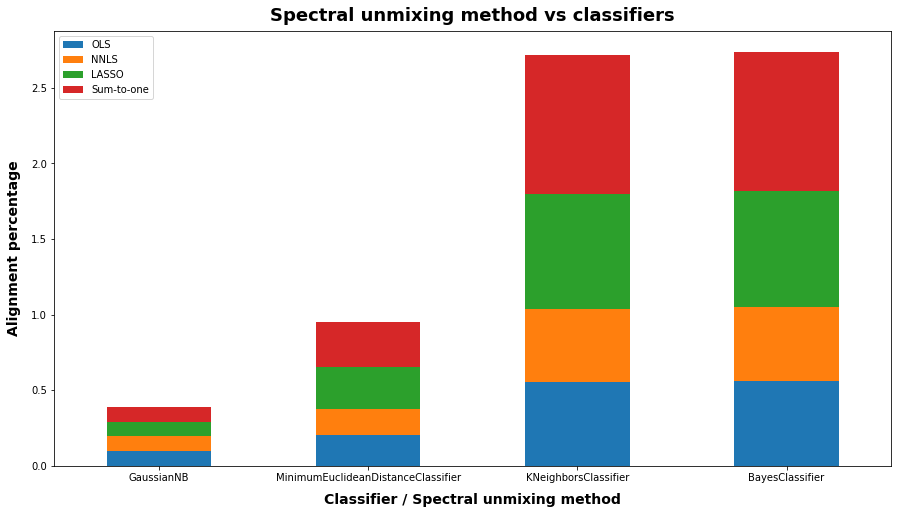

In [64]:
# Stack the results
all_spectral_vs_classifiers = np.vstack([
    ols_vs_all_result, 
    nnls_vs_all_result, 
    lasso_vs_all_result, 
    nn_sum_to_one_vs_all_result
])

all_spectral_vs_classifiers_df = pd.DataFrame(
    data = all_spectral_vs_classifiers[:, 2].reshape(4, 4),
    columns = [
        "OLS",
        "NNLS",
        "LASSO",
        "Sum-to-one"
    ],
    index = [
        "GaussianNB",
        "MinimumEuclideanDistanceClassifier",
        "KNeighborsClassifier",
        "BayesClassifier"
    ]
)

all_spectral_vs_classifiers_df

# Setup the plot
fig, ax = plt.subplots(figsize = (15, 8))

all_spectral_vs_classifiers_df.plot(ax = ax, kind = "bar", stacked = True)

# Set graph labels
ax.set_xlabel("Classifier / Spectral unmixing method", fontdict = plot_axis_title_font, labelpad = 10)
ax.set_ylabel("Alignment percentage", fontdict = plot_axis_title_font, labelpad = 10)

plt.xticks(rotation = 0)

# Set graph title
ax.set_title(label = "Spectral unmixing method vs classifiers", loc = "center", fontdict = plot_main_title_font, pad = 10)

pass;

### Conclusion

It appears that, the more abiding to the true nature of the problem and / or normalized the paramater vector $\boldsymbol{\theta}$ is, according to the unmixing method selected, the more the abundance maps represent with accuracy the mixing of "pure" pixels in the image pixel. This notion is supported by the classification problem, in which classifiers with better performance in predicting the true class of a pixel are aligned with the spectral unmixing method, in terms of "alignment" score.

---